In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.integrate import quad
from qiskit.quantum_info.states import Statevector, DensityMatrix
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info.operators import SuperOp, Choi, Kraus, PTM

from qiskit_ode import solve_ode, solve_lmde
from qiskit_ode.signals import Signal
from qiskit_ode.models import HamiltonianModel, LindbladModel


def gaussian(amp, sig, t0, t):
    return amp * np.exp( -(t - t0)**2 / (2 * sig**2) )

# In this demo

This notebook demonstrates some of the core model building and differential equation solving elements:
- Hamiltonian and signal construction
- Model transformations: entering a frame, making a rotating wave approximation
- Defining and solving differential equations

Sections
1. `Signal`s
2. Constructing a `HamiltonianModel`
3. Setting `frame` and `cutoff_freq` in `HamiltonianModel`
4. Integrating the Schrodinger equation
5. Adding dissipative dynamics with a `LindbladModel` and simulating density matrix evolution
6. Simulate the Lindbladian to get a `SuperOp` representation of the quantum channel

# 1. `Signal`

A `Signal` object represents a complex mixed signal, i.e. a function of the form: 
\begin{equation}
    s(t) = f(t)e^{i2 \pi \nu t},
\end{equation}
where $f(t)$ is the *envelope* and $\nu$ is the *carrier frequency*.

Here we define a signal with a Gaussian envelope:

In [2]:
amp = 1. # amplitude
sig = 2. # sigma
t0 = 3.5*sig # center of Gaussian
T = 7*sig # end of signal

gaussian_envelope = lambda t: gaussian(amp, sig, t0, t)

gauss_signal = Signal(envelope=gaussian_envelope, carrier_freq=0.5)

In [3]:
print(gauss_signal.envelope(0.25))
print(gauss_signal(0.25))

0.0033616864879322562
0.0023770713118400873


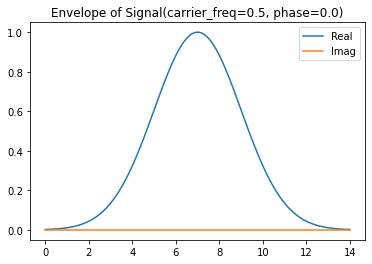

In [4]:
gauss_signal.draw(0, T, 100, function='envelope')

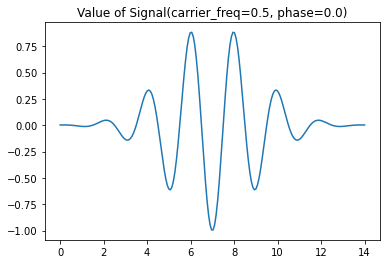

In [5]:
gauss_signal.draw(0, T, 200)

# 2. The `HamiltonianModel` class

A `HamiltonianModel` is specified as a list of Hermitian operators with `Signal` coefficients. Here, we use a classic qubit model:
\begin{equation}
    H(t) = 2 \pi \nu \frac{Z}{2} + 2 \pi r s(t) \frac{X}{2}.
\end{equation}

Generally, a `HamiltonianModel` represents a linear combination:
\begin{equation}
    H(t) = \sum_j s_j(t) H_j,
\end{equation}
where: 
 - $H_j$ are Hermitian operators given as `terra.quantum_info.Operator` objects, and 
 - $s_j(t) = Re[f_j(t)e^{i2 \pi \nu_j t}]$, where the complex functions $f_j(t)e^{i2 \pi \nu_j t}$ are specified as `Signal` objects.

Constructing a `HamiltonianModel` requires specifying lists of the operators and the signals.

In [6]:
#####################
# construct operators
#####################
r = 0.5
w = 1.
X = Operator.from_label('X')
Y = Operator.from_label('Y')
Z = Operator.from_label('Z')

operators = [2 * np.pi * w * Z/2, 
             2 * np.pi * r * X/2]

###################
# construct signals
###################

# Define gaussian envelope function to have max amp and area approx 2 
amp = 1.
sig = 0.399128/r
t0 = 3.5*sig
T = 7*sig
gaussian_envelope = lambda t: gaussian(amp, sig, t0, t)

signals = [1., 
           Signal(envelope=gaussian_envelope, carrier_freq=w)]

#################
# construct model
#################

hamiltonian = HamiltonianModel(operators=operators, signals=signals)

## 2.1 Evaluation and drift

Evaluate at a given time.

In [7]:
print(hamiltonian.evaluate(0.12))

[[ 3.14159265+0.j  0.00419151+0.j]
 [ 0.00419151+0.j -3.14159265+0.j]]


Get the drift (terms corresponding to constant coefficients).

In [8]:
hamiltonian.drift

Array([[ 3.14159265+0.j,  0.        +0.j],
       [ 0.        +0.j, -3.14159265+0.j]], backend='numpy')

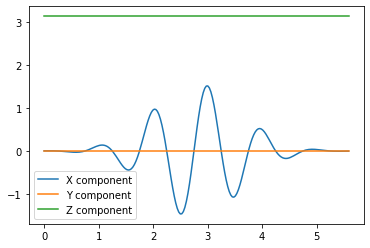

In [9]:
def plot_qubit_hamiltonian_components(hamiltonian, t0, tf, N=200):
    t_vals = np.linspace(t0, tf, N)
    model_vals = np.array([hamiltonian.evaluate(t) for t in t_vals])
    x_coeff = model_vals[:, 0, 1].real
    y_coeff = -model_vals[:, 0, 1].imag
    z_coeff = model_vals[:, 0, 0].real
    plt.plot(t_vals, x_coeff, label='X component')
    plt.plot(t_vals, y_coeff, label='Y component')
    plt.plot(t_vals, z_coeff, label='Z component')
    plt.legend()

plot_qubit_hamiltonian_components(hamiltonian, 0., T)

## 2.2 Enter a rotating frame

We can specify a frame to enter the Hamiltonian in. Given a Hermitian operator $H_0$, *entering the frame* of $H_0$ means transforming a Hamiltonian $H(t)$:
\begin{equation}
    H(t) \mapsto \tilde{H}(t) = e^{i H_0 t}H(t)e^{-iH_0 t} - H_0
\end{equation}

Here, we will enter the frame of the drift Hamiltonian, resulting in:
\begin{equation}
\begin{aligned}
    \tilde{H}(t) &= e^{i2 \pi \nu \frac{Z}{2} t}\left(2 \pi \nu \frac{Z}{2} + 2 \pi r s(t) \frac{X}{2}\right)e^{-i2 \pi \nu \frac{Z}{2} t} - 2 \pi \nu \frac{Z}{2} \\
                &= 2 \pi r s(t) e^{i2 \pi \nu \frac{Z}{2} t}\frac{X}{2}e^{-i2 \pi \nu \frac{Z}{2} t}\\
                &= 2 \pi r s(t) \left[\cos(2 \pi \nu t) \frac{X}{2} - \sin(2 \pi \nu t) \frac{Y}{2} \right]
\end{aligned}
\end{equation}

In [10]:
hamiltonian.frame = hamiltonian.drift

Evaluate again.

In [11]:
print(hamiltonian.evaluate(0.12))

[[0.        +0.j         0.00305548+0.00286929j]
 [0.00305548-0.00286929j 0.        +0.j        ]]


In [12]:
# validate with independent computation
t = 0.12
2 * np.pi * r * np.real(signals[1](t)) * (np.cos(2*np.pi * w * t) * X / 2 
                                                - np.sin(2*np.pi * w * t) * Y / 2 )

Operator([[0.        +0.j        , 0.00305548+0.00286929j],
          [0.00305548-0.00286929j, 0.        +0.j        ]],
         input_dims=(2,), output_dims=(2,))

Replot the coefficients of the model in the Pauli basis over time.

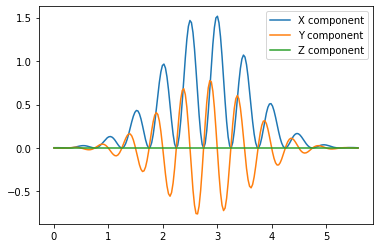

In [13]:
plot_qubit_hamiltonian_components(hamiltonian, 0., T)

# 3. Set cutoff frequency (rotating wave approximation)

A common technique to simplify the dynamics of a quantum system is to perform the *rotating wave approximation* (RWA), in which terms with high frequency are averaged to $0$.

The RWA can be applied on any `HamiltonianModel` (in the given `frame`) by setting the `cutoff_freq` attribute, which sets any fast oscillating terms to $0$, effectively performing a moving average on terms with carrier frequencies above `cutoff_freq`.

For our model, the classic `cutoff_freq` is $2 \nu$ (twice the qubit frequency). This approximates the Hamiltonian $\tilde{H}(t)$ as:
\begin{equation}
    \tilde{H}(t) \approx 2 \pi \frac{r}{2} \left[Re[f(t)] \frac{X}{2} + Im[f(t)] \frac{Y}{2} \right],
\end{equation}
where $f(t)$ is the envelope of the on-resonance drive. On our case $f(t) = Re[f(t)]$, and so we simply have
\begin{equation}
    \tilde{H}(t) \approx 2 \pi \frac{r}{2} Re[f(t)] \frac{X}{2},
\end{equation}

In [14]:
# set the cutoff frequency
hamiltonian.cutoff_freq = 2*w

In [15]:
# evaluate again
print(hamiltonian.evaluate(0.12))

[[0.        +0.00000000e+00j 0.00287496-2.16840434e-19j]
 [0.00287496+2.16840434e-19j 0.        +0.00000000e+00j]]


We also plot the coefficients of the model in the frame of the drift with the RWA applied. We now expect to see simply a plot of $\pi \frac{r}{2} f(t)$ for the $X$ coefficient. 

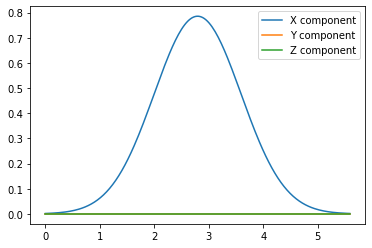

In [16]:
plot_qubit_hamiltonian_components(hamiltonian, 0., T)

# 4. Solve Shrodinger equation with a `HamiltonianModel`

To solve the Schrodinger Equation for the given Hamiltonian, we construct a `SchrodingerProblem` object, which specifies the desired simulation.

In [17]:
# reset the frame and cutoff_freq properties
hamiltonian.frame = None
hamiltonian.cutoff_freq = None

In [18]:
# solve the problem, with some options specified
y0 = Statevector([0., 1.])
%time sol = solve_lmde(hamiltonian, t_span=[0., T], y0=y0, atol=1e-10, rtol=1e-10)
y = sol.y[-1]
print("\nFinal state:")
print("----------------------------")
print(y)
print("\nPopulation in excited state:")
print("----------------------------")
print(np.abs(y.data[0])**2)

CPU times: user 406 ms, sys: 2.6 ms, total: 409 ms
Wall time: 407 ms

Final state:
----------------------------
Statevector([0.96087419-0.27193942j 0.0511707 +0.01230027j])

Population in excited state:
----------------------------
0.9972302627366899


When specifying a problem, we can specify which frame to solve in, and a cutoff frequency to solve with.

In [19]:
%time sol = solve_lmde(hamiltonian, t_span=[0., T], y0=y0, solver_cutoff_freq=2*w, atol=1e-10, rtol=1e-10)
y = sol.y[-1]
print("\nFinal state:")
print("----------------------------")
print(y)
print("\nPopulation in excited state:")
print("----------------------------")
print(np.abs(y.data[0])**2)

CPU times: user 159 ms, sys: 9.9 ms, total: 169 ms
Wall time: 162 ms

Final state:
----------------------------
Statevector([ 9.62205827e-01-2.72323239e-01j
             -2.36278329e-08+8.34847474e-08j])

Population in excited state:
----------------------------
0.9999999999756191


# 4.1 Technical solver notes:
- Behind the scenes, the `SchrodingerProblem` constructs an `OperatorModel` from the `HamiltonianModel`, representing the generator in the Schrodinger equation:
\begin{equation}
    G(t) = \sum_j s_j(t)\left[-iH_j\right]
\end{equation}
which is then pass used in a generalized routine for solving DEs of the form $y'(t) = G(t)y(t)$
- The generalized solver routine will automatically solve the DE in the drift frame, as well as in the basis in which the drift is diagonal (relevent for non-diagonal drift operators, to save on exponentiations for the frame operator).

# 5. Solving with dissipative dynamics 

To simulate with noise operators, we define a `LindbladModel`, containing:
- a model of a Hamiltonian (specified with either a `HamiltonianModel` object, or in the standard decomposition of operators and signals)
- an optional list of noise operators
- an optional list of time-dependent coefficients for the noise operators

Such a system is simulated in terms of the Lindblad master equation:
\begin{equation}
    \dot{\rho}(t) = -i[H(t), \rho(t)] + \sum_j g_j(t) \left(L_j \rho L_j^\dagger - \frac{1}{2}\{L_j^\dagger L_j, \rho(t)\}\right),
\end{equation}
where
- $H(t)$ is the Hamiltonian,
- $L_j$ are the noise operators, and
- $g_j(t)$ are the noise coefficients

Here we will construct such a model using the above `Hamitonian`, along with a noise operator that drives the state to the ground state.

In [20]:
# construct quantum model with noise operators
noise_ops = [np.array([[0., 0.], 
                       [1., 0.]])]
noise_signals = [0.001]
lindblad_model = LindbladModel.from_hamiltonian(hamiltonian=hamiltonian, 
                                                noise_operators=noise_ops,
                                                noise_signals=noise_signals)

# density matrix
y0 = DensityMatrix([[0., 0.], [0., 1.]])

%time sol = solve_lmde(lindblad_model, t_span=[0., T], y0=y0, atol=1e-10, rtol=1e-10)
sol.y[-1]

CPU times: user 497 ms, sys: 9.5 ms, total: 506 ms
Wall time: 500 ms


[[0.99473642+4.25007252e-17j 0.04620048-2.49934328e-02j]
 [0.04620048+2.49934328e-02j 0.00526358+1.11022302e-16j]]

We may also simulate the Lindblad equation with a cutoff frequency.

In [21]:
%time sol = solve_lmde(lindblad_model, t_span=[0., T], y0=y0, solver_cutoff_freq=2*w, atol=1e-10, rtol=1e-10)
sol.y[-1]

CPU times: user 480 ms, sys: 6.35 ms, total: 486 ms
Wall time: 482 ms


[[0.99614333-1.01047642e-16j 0.01049406-3.50564736e-02j]
 [0.01049406+3.50564736e-02j 0.00252446-1.11022302e-16j]]

## 5.1 Technical notes

- Similarly to the flow of `SchrodingerProblem`, `LindbladProblem` constructs an `OperatorModel` representing the *vectorized* Lindblad equation, which is then used to simulate the Lindblad equation on the vectorized density matrix.
- Frame handling and cutoff frequency handling are handled at the `OperatorModel` level, and hence can be used here as well.

## 5.2 Simulate the Lindbladian/SuperOp

In [22]:
# identity quantum channel in superop representation
y0 = SuperOp(np.eye(4))

%time sol = solve_lmde(lindblad_model, t_span=[0., T], y0=y0, atol=1e-10, rtol=1e-10)
print(sol.y[-1])

CPU times: user 546 ms, sys: 2.95 ms, total: 549 ms
Wall time: 547 ms
SuperOp([[ 0.00523988+1.59454572e-17j,  0.05230901-2.08651875e-03j,
           0.05230901+2.08651875e-03j,  0.99473642-1.15445593e-16j],
         [-0.04508833-2.62771380e-02j,  0.00223689+1.07542007e-03j,
          -0.84671078-5.20988650e-01j,  0.04620048+2.49934329e-02j],
         [-0.04508833+2.62771380e-02j, -0.84671078+5.20988650e-01j,
           0.00223689-1.07542007e-03j,  0.04620048-2.49934329e-02j],
         [ 0.99476012+6.24401295e-17j, -0.05230901+2.08651875e-03j,
          -0.05230901-2.08651875e-03j,  0.00526358-9.89206549e-18j]],
        input_dims=(2,), output_dims=(2,))


In [23]:
print(PTM(y))

PTM([[ 5.00000000e-01+0.j, -4.54696754e-08+0.j,  7.38951024e-08+0.j,
       5.00000000e-01+0.j],
     [-4.54696754e-08+0.j,  4.13498276e-15+0.j, -6.71997263e-15+0.j,
      -4.54696754e-08+0.j],
     [ 7.38951024e-08+0.j, -6.71997263e-15+0.j,  1.09209723e-14+0.j,
       7.38951024e-08+0.j],
     [ 5.00000000e-01+0.j, -4.54696754e-08+0.j,  7.38951024e-08+0.j,
       5.00000000e-01+0.j]],
    input_dims=(2,), output_dims=(2,))
